## Gillespie simulator

This file contains a Gillespie simulator for the reaction
Borrowed from Markus Dittrich

<code>
   A + B -> C  [k1]
   C -> A + B  [k2]
</code>

http://staff.psc.edu/dittrich/PGSS/pdfs/Gillespie_1977.pdf

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:

# import pythons random number generator
# NOTE: for production code you need to make sure to have
# a very good random number generator.
import random as rng
import math
import numpy as np
import matplotlib.pylab as plt

In [24]:
from helper2 import *

### Define gillespie simulator

#### <font color=red>Need to explain each routine in helper etc</font>

In [25]:



################################################################
# start of main simulation
################################################################

def main(
    # parameters
    A0 = 30110, # initial molecule count for species A
    B0 =     0, # initial molecule count for species B
    C0 =     0, # initial molecule count for species C
    k1 = 0.024e5,           # forward rate [#/(Mol*s)]
    k2 = 0.015e5,           # backward rate [1/s]
    volume = 5e-20,         # reaction volume [L]
    maxTime = 1.0e-2,   # maximum simulation time [s]
    outputFreq = 1000,                            # output frequency
    verbose = False
):

    # initialize time, random number generator,
    # initial molecule counts, and molecule count update
    # functions
    rng.seed(124213)
    N_avo  = 6.0221415e23  
    time       = 0.0
    iteration  = 0 # iteration count
    molCounts  = [A0,B0,C0]
    rates      = [k1/volume/N_avo, k2]           # need to convert 
    updaters   = [react1_updater,react2_updater]

    # open output files
    fileHandles = open_output_files() 
    results = dict()
    results["time"]=[]
    results["molCounts"]=[]
    results["molConcs"]=[]
    
    # we simulate until we hit our maximum simulation time
    while time < maxTime:
    #for i in np.arange(10000):
        
        # compute the propensities a_i for each reaction
        # and the sum a_0
        a_i = compute_propensities(molCounts, rates)
        a_0 = sum(a_i)

        # pick a random number, compute the time increment
        # and update t (equation 21a in Gillespie's paper)
        rand_1 = rng.random()
        tau    = 1.0/a_0 * math.log(1/rand_1)
        time  += tau

        # find the reaction to execute (equation 21b in
        # Gillespie's paper). We need a second random number
        # here. We don't really need the while loop here since
        # we only have two possible reactions but we do it anyway
        # to keep it more general. 
        rand_2    = rng.random()
        threshold = a_0 * rand_2
        
        summation = 0
        count     = 0
        while threshold > summation:
            summation += a_i[count]
            count += 1
            
        # update molecule counts by calling the proper updater
        # function. Note, arrays in python are zero index based
        # hence we need count-1 to access the proper updater.
        molCounts = updaters[count-1](molCounts)

        # dump data every outputFreq iteration
        # we also print a short progess message 
        if (iteration % outputFreq) == 0:
            if verbose: 
              print "iteration %d   time %5.4g" % (iteration, time)  
            
            # store 
            results["time"].append(time)
            molCts = np.copy(molCounts)
            molConcs = molCts/volume/N_avo
            results["molCounts"].append(molCts)
            results["molConcs"].append(molConcs)
            #print molCounts
            #print "###",results["molCounts"]
            write_data_to_output(fileHandles, time, molConcs)

        iteration += 1    

    
    # cleanup
    close_output_files(fileHandles)


    # reformat
    for key in results.keys():
      results[key] = np.asarray( results[key] )
   
    return results       

### Define input parameters

In [45]:

###############################################################
# initial conditions and variables
###############################################################

# initial molecule counts
A0 = 30110
B0 = 0
C0 = 0

# Reaction volume
volume = 5e-20         # in l


# initial rates
k1 = 0.024e7           # units are #/(Mol*s)
k2 = 0.015e-2           # units are 1/s



In [46]:
k1/k2

1600000000.0000002

### Simulate 

In [47]:
results = main(
  A0 = A0,
  B0 = B0,
  C0 = C0,
  k1 = k1,
  k2 = k2,
  maxTime=10,  
  verbose=True
)


iteration 0   time 3.559e-06
iteration 1000   time 0.004385
iteration 2000   time 0.008845
iteration 3000   time 0.01343
iteration 4000   time 0.01828
iteration 5000   time 0.02313
iteration 6000   time 0.02821
iteration 7000   time 0.03382
iteration 8000   time 0.03922
iteration 9000   time 0.04483
iteration 10000   time 0.05072
iteration 11000   time 0.05718
iteration 12000   time 0.06404
iteration 13000   time 0.07105
iteration 14000   time 0.07816
iteration 15000   time 0.08657
iteration 16000   time 0.09524
iteration 17000   time 0.1041
iteration 18000   time 0.1141
iteration 19000   time 0.1251
iteration 20000   time 0.1368
iteration 21000   time 0.1502
iteration 22000   time 0.1649
iteration 23000   time 0.1818
iteration 24000   time 0.2006
iteration 25000   time 0.2225
iteration 26000   time 0.2499
iteration 27000   time 0.2869
iteration 28000   time 0.3364
iteration 29000   time 0.4171
iteration 30000   time 0.7119


### Load and plot results 

In [48]:
ts = results['time']
molCounts = results['molCounts']
molConcs = results['molConcs']

109
30001
0


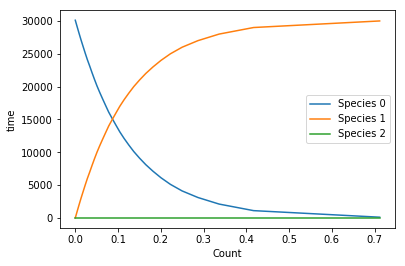

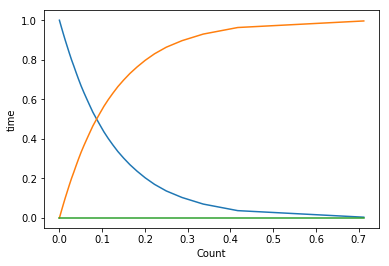

In [49]:
plt.figure()
for i in np.arange(3):
  plt.plot(ts,molCounts[:,i],label="Species %d"%i)
  print molCounts[-1,i]
plt.xlabel("Count")
plt.ylabel("time")
plt.legend()


plt.figure()
for i in np.arange(3):
  plt.plot(ts,molConcs[:,i],label="Species %d"%i)
plt.xlabel("Count")
plt.ylabel("time")
